In [ ]:
# this package requires numpy version 1.23.5!!!

!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 79.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
bigframes 2.8.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which

In [1]:
import gym
print(f"gym Version: {gym.__version__}")
import numpy as np
print(f"numpy Version: {np.__version__}")
import matplotlib.pyplot as plt
from collections import defaultdict
import random


gym Version: 0.25.2
numpy Version: 1.23.5


In [16]:
# Set up the CartPole environment
env = gym.make("CartPole-v1")
n_actions = env.action_space.n

# Discretize continuous state space
n_bins = (24, 24, 24, 24) # bins for each state variable

obs_space_low = env.observation_space.low
obs_space_high = env.observation_space.high
obs_space_high[1] = 5
obs_space_low[1] = -5
obs_space_high[3] = 5
obs_space_low[3] = -5

def discretize(obs):
    ratios = [(obs[i] - obs_space_low[i]) / (obs_space_high[i] - obs_space_low[i]) for i in range(len(obs))]
    new_obs = [int(np.floor(ratios[i] * n_bins[i])) for i in range(len(obs))]
    new_obs = [min(n_bins[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
    return tuple(new_obs)

# Initialize Q-table
Q = defaultdict(lambda: np.zeros(n_actions))

In [17]:
# Q-learning hyperparameters
alpha = 0.1       # learning rate
gamma = 0.99       # discount factor
epsilon = 1.0      # exploration rate
epsilon_decay = 0.999
epsilon_min = 0.01
n_episodes = 5000

In [18]:
rewards_per_episode = []

# Q-learning loop
for episode in range(n_episodes):
    obs = env.reset()
    state = discretize(obs[0] if isinstance(obs, tuple) else obs)
    total_reward = 0

    done = False
    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_obs, reward, done, _, = env.step(action)
        next_state = discretize(next_obs)
        total_reward += reward

        # Update Q-value
        best_next_action = np.argmax(Q[next_state])
        td_target = reward + gamma * Q[next_state][best_next_action]
        td_delta = td_target - Q[state][action]
        Q[state][action] += alpha * td_delta

        state = next_state

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

    if (episode + 1) % (n_episodes/10) == 0:
        print(f"Episode {episode + 1}: reward={total_reward}, epsilon={epsilon:.3f}")

env.close()


Episode 500: reward=45.0, epsilon=0.606
Episode 1000: reward=94.0, epsilon=0.368
Episode 1500: reward=300.0, epsilon=0.223
Episode 2000: reward=133.0, epsilon=0.135
Episode 2500: reward=169.0, epsilon=0.082
Episode 3000: reward=500.0, epsilon=0.050
Episode 3500: reward=262.0, epsilon=0.030
Episode 4000: reward=500.0, epsilon=0.018
Episode 4500: reward=500.0, epsilon=0.011
Episode 5000: reward=500.0, epsilon=0.010


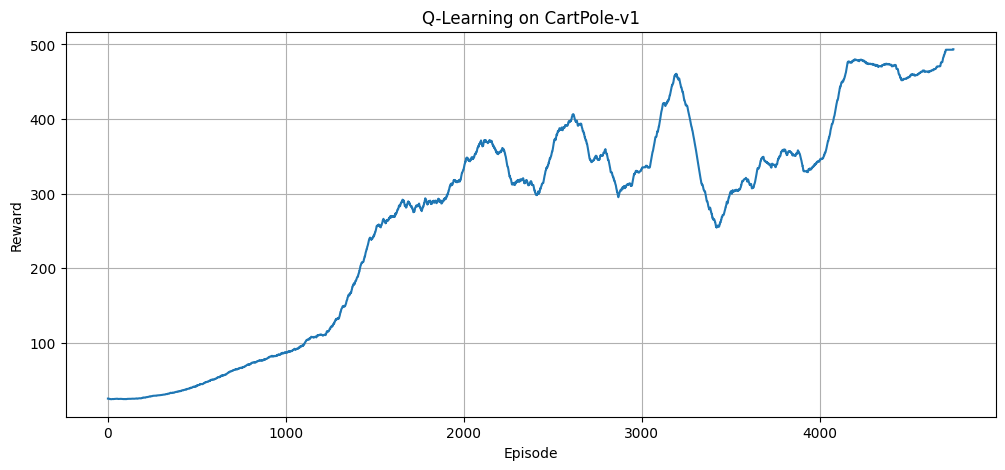

In [26]:
# Plot training performance
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 5))
plt.plot(moving_average(rewards_per_episode, 250))
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Q-Learning on CartPole-v1")
plt.grid(True)
plt.show()